In [36]:
import sys
assert sys.version_info >= (3, 5) # make sure we have Python 3.5+
import re
import math
from pyspark.sql.window import Window
from pyspark.sql import SparkSession, functions, types
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, SQLTransformer
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor,DecisionTreeRegressor,GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
from pyspark.ml.feature import MinMaxScaler
import pandas as pd
spark = SparkSession.builder.appName('example code').getOrCreate()
assert spark.version >= '2.4' # make sure we have Spark 2.4+
spark.sparkContext.setLogLevel('WARN')
sc = spark.sparkContext
spark.conf.set('spark.sql.session.timeZone', 'UTC')

bitcoin_schema = types.StructType([
    types.StructField('Date', types.StringType()),
    types.StructField('Symbol', types.StringType()),
    types.StructField('Open', types.FloatType()),
    types.StructField('High', types.FloatType()),
    types.StructField('Low', types.FloatType()),
    types.StructField('Close', types.FloatType()),
    types.StructField('Volume BTC', types.FloatType()),
    types.StructField('Volume USD', types.FloatType()),
])
tweets_schema = types.StructType([
    types.StructField('Date', types.StringType()),
    types.StructField('tweet', types.StringType())
])

In [37]:
col_order = ["timestamp", "Open", "High", "Low", "Close", "Volume BTC", "Volume USD"]
tweet_col = ['negative', "netural", "positive", "compound"]

In [39]:
bitcoin_df = spark.read.csv("bitcoin-usd-history.csv", schema=bitcoin_schema).cache()
bitcoin_df = bitcoin_df.withColumn("timestamp", functions.unix_timestamp("Date", 'yyyy-MM-dd hh-aa').cast("timestamp")).drop('Date')
bitcoin_df = bitcoin_df.select(col_order).where(
    (functions.unix_timestamp(functions.lit('2019-11-17 00:00:00')).cast('timestamp') > bitcoin_df["timestamp"]) & 
    (bitcoin_df["timestamp"] >= functions.unix_timestamp(functions.lit('2019-11-16 00:00:00')).cast('timestamp'))).sort("timestamp").cache()
bitcoin_df = bitcoin_df.select(functions.hour("timestamp").alias("hour"), "Close")
bitcoin_df.show(24)

+----+-------+
|hour|  Close|
+----+-------+
|   0|8766.18|
|   1|8763.11|
|   2|8743.32|
|   3| 8764.7|
|   4|8774.53|
|   5| 8779.0|
|   6|8768.66|
|   7|8759.11|
|   8| 8773.6|
|   9|8792.58|
|  10|8792.42|
|  11|8767.85|
|  12|8779.67|
|  13|8770.65|
|  14|8767.61|
|  15| 8792.0|
|  16|8789.78|
|  17|8764.79|
|  18| 8765.0|
|  19|8761.04|
|  20|8764.53|
|  21|8779.13|
|  22|8767.18|
|  23|8774.37|
+----+-------+



In [40]:
tweet_df = spark.read.csv("tweets.csv", schema=tweets_schema)
tweet_df = tweet_df.withColumn("timestamp", functions.unix_timestamp("Date", 'yyyy-MM-dd HH:mm:ss').cast("timestamp")).drop('Date')
tweet_df = tweet_df.select("timestamp", "tweet").sort("timestamp").cache()
tweet_df = tweet_df.na.drop()

tweet_df.show(3)

+-------------------+--------------------+
|          timestamp|               tweet|
+-------------------+--------------------+
|2019-11-16 00:00:01|b'New Topic *Cono...|
|2019-11-16 00:00:01|b'1 cent = 118 sa...|
|2019-11-16 00:00:02|b'11/16 09:00\xe7...|
+-------------------+--------------------+
only showing top 3 rows



In [41]:
import preprocessor as p
@functions.udf(returnType=types.StringType())
def func_udf(input_str):
    input_str = re.sub(r'b', '', input_str)
    p.set_options(p.OPT.URL, p.OPT.EMOJI,p.OPT.MENTION)
    input_str = p.clean(input_str)
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", input_str).split())
# func_udf = udf(function_udf, StringType())
#     return p.clean(input_str)
    return intput_str
CleanDF = tweet_df.withColumn('CleanedTweets', func_udf(tweet_df['tweet'])).drop("tweet")
CleanDF.show(3)

+-------------------+--------------------+
|          timestamp|       CleanedTweets|
+-------------------+--------------------+
|2019-11-16 00:00:01|New Topic Conor M...|
|2019-11-16 00:00:01|1 cent 118 sats s...|
|2019-11-16 00:00:02|11 16 09 00 xe7 x...|
+-------------------+--------------------+
only showing top 3 rows



In [42]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

@functions.udf(returnType=types.ArrayType(types.FloatType()))
def senti_score(sentence):
    snt = analyser.polarity_scores(sentence)
    return ([snt['neg'], snt['neu'], snt['pos'], snt['compound']])

CleanDF = CleanDF.withColumn('negative', senti_score(CleanDF['CleanedTweets'])[0])
CleanDF = CleanDF.withColumn('netural', senti_score(CleanDF['CleanedTweets'])[1])
CleanDF = CleanDF.withColumn('positive', senti_score(CleanDF['CleanedTweets'])[2])
CleanDF = CleanDF.withColumn('compound', senti_score(CleanDF['CleanedTweets'])[3])
CleanDF.show(20)

+-------------------+--------------------+--------+-------+--------+--------+
|          timestamp|       CleanedTweets|negative|netural|positive|compound|
+-------------------+--------------------+--------+-------+--------+--------+
|2019-11-16 00:00:01|New Topic Conor M...|     0.0|    1.0|     0.0|     0.0|
|2019-11-16 00:00:01|1 cent 118 sats s...|     0.0|    1.0|     0.0|     0.0|
|2019-11-16 00:00:02|11 16 09 00 xe7 x...|     0.0|    1.0|     0.0|     0.0|
|2019-11-16 00:00:02|The Bitcoin BTC p...|     0.0|    1.0|     0.0|     0.0|
|2019-11-16 00:00:02|Bitcoin BTC nPric...|     0.0|    1.0|     0.0|     0.0|
|2019-11-16 00:00:03|MercadoBitcoin BT...|     0.0|  0.636|   0.364|  0.6486|
|2019-11-16 00:00:03|xe2 x8f x0 03 00 ...|     0.0|    1.0|     0.0|     0.0|
|2019-11-16 00:00:03|NOW SHILLING SHIN...|     0.0|    1.0|     0.0|     0.0|
|2019-11-16 00:00:03|BitcoinAverage it...|     0.0|    1.0|     0.0|     0.0|
|2019-11-16 00:00:04|One Bitcoin now w...|     0.0|  0.888|   0.

In [43]:
GroupDF = CleanDF.sort("timestamp").withColumn("hour", functions.hour("timestamp")).show()

+-------------------+--------------------+--------+-------+--------+--------+----+
|          timestamp|       CleanedTweets|negative|netural|positive|compound|hour|
+-------------------+--------------------+--------+-------+--------+--------+----+
|2019-11-16 00:00:01|New Topic Conor M...|     0.0|    1.0|     0.0|     0.0|   0|
|2019-11-16 00:00:01|1 cent 118 sats s...|     0.0|    1.0|     0.0|     0.0|   0|
|2019-11-16 00:00:02|11 16 09 00 xe7 x...|     0.0|    1.0|     0.0|     0.0|   0|
|2019-11-16 00:00:02|The Bitcoin BTC p...|     0.0|    1.0|     0.0|     0.0|   0|
|2019-11-16 00:00:02|Bitcoin BTC nPric...|     0.0|    1.0|     0.0|     0.0|   0|
|2019-11-16 00:00:03|NOW SHILLING SHIN...|     0.0|    1.0|     0.0|     0.0|   0|
|2019-11-16 00:00:03|xe2 x8f x0 03 00 ...|     0.0|    1.0|     0.0|     0.0|   0|
|2019-11-16 00:00:03|BitcoinAverage it...|     0.0|    1.0|     0.0|     0.0|   0|
|2019-11-16 00:00:03|MercadoBitcoin BT...|     0.0|  0.636|   0.364|  0.6486|   0|
|201

In [44]:
# GroupDF.sort("hour").show(25)

In [19]:
w =Window.partitionBy().orderBy(functions.col("hour").cast('long'))
join_df = GroupDF.join(bitcoin_df, GroupDF["hour"] == bitcoin_df["hour"]).select(GroupDF["*"],bitcoin_df["Close"])
join_df = join_df.sort("hour").withColumn("Price", functions.lag("Close", count=-1).over(w))
join_df = join_df.select("hour", "Price", "negative", "netural", "positive", "compound").na.drop()

In [20]:
join_df.show(24)

+----+-------+--------------------+------------------+-------------------+-------------------+
|hour|  Price|            negative|           netural|           positive|           compound|
+----+-------+--------------------+------------------+-------------------+-------------------+
|   0|8763.11|  0.0383815026890508|0.8871098259797675|0.07451156058989336|0.10336734028263933|
|   1|8743.32| 0.02983643120106268| 0.892609664941809|0.07756505582523168|  0.095049069931239|
|   2| 8764.7|0.025603225983438952|0.8941225807032277| 0.0802838712329826| 0.1318983856949114|
|   3|8774.53|    0.01626720650476|0.9080607287796886|0.07567611350282001| 0.1590238854379548|
|   4| 8779.0|0.019636363722383976|0.8967992418417425|0.08356439384321372|0.15350568071572165|
|   5|8768.66|0.021247899238051485|0.9036890739152411|0.07506302496840973| 0.1483575618442367|
|   6|8759.11|0.017874125964366473|0.9071783208763683| 0.0749475526773221|0.16770874070641878|
|   7| 8773.6| 0.02463636359651432| 0.908185604508

In [26]:
for feature in tweet_col:
    for diff in range(1, 4):
        name = feature + "_lag_{}".format(diff)
        join_df = join_df.withColumn(name, functions.lag(join_df[feature], count=diff).over(w))

join_df = join_df.na.drop()
join_df.show(2)

+----+-------+--------------------+------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
|hour|  Price|            negative|           netural|           positive|           compound|      negative_lag_1|      negative_lag_2|      negative_lag_3|      negative_lag_4|      negative_lag_5|     netural_lag_1|     netural_lag_2|     netural_lag_3|     netural_lag_4|     netural_lag_5|     positive_lag_1|     positive_lag_2|     positive_lag_3|     positive_lag_4|     positive_lag_5|     compound_lag_1|     compound_lag_2|     compound_lag_3|     compound_lag_4|     compound_lag_5|
+----+----

In [27]:
join_df.select("hour", "Price").show()

+----+-------+
|hour|  Price|
+----+-------+
|   8|8792.58|
|   9|8792.42|
|  10|8767.85|
|  11|8779.67|
|  12|8770.65|
|  13|8767.61|
|  14| 8792.0|
|  15|8789.78|
|  16|8764.79|
|  17| 8765.0|
|  18|8761.04|
|  19|8764.53|
|  20|8779.13|
|  21|8767.18|
|  22|8774.37|
+----+-------+



In [29]:
featureCols = []
for feature in tweet_col:
    featureCols.append(feature)
    for diff in range(1, 4):
        featureCols.append(feature + "_lag_{}".format(diff))
featureCols

['negative',
 'negative_lag_1',
 'negative_lag_2',
 'negative_lag_3',
 'netural',
 'netural_lag_1',
 'netural_lag_2',
 'netural_lag_3',
 'positive',
 'positive_lag_1',
 'positive_lag_2',
 'positive_lag_3',
 'compound',
 'compound_lag_1',
 'compound_lag_2',
 'compound_lag_3']

In [30]:
assembler = VectorAssembler(
        inputCols= featureCols,
        outputCol='features'

)

regressor = LinearRegression(featuresCol = 'features', labelCol = 'Price')

In [31]:
pipeline = Pipeline(stages=[assembler, regressor])
model = pipeline.fit(join_df)

In [34]:
predictions = model.transform(join_df)
someDF = predictions.select("prediction", "Price").show(5)

+-----------------+-------+
|       prediction|  Price|
+-----------------+-------+
|8792.072853132966|8792.58|
|8792.655090012762|8792.42|
| 8767.99262128357|8767.85|
|8779.049939257617|8779.67|
|8773.374289629573|8770.65|
+-----------------+-------+
only showing top 5 rows



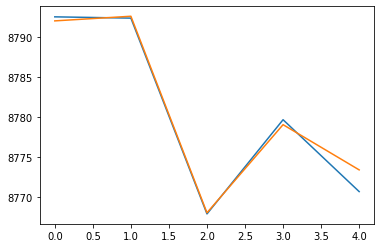

In [35]:
predictions = predictions.toPandas().head()
plt.plot(predictions['Price'])
plt.plot(predictions['prediction'])
plt.show()

In [ ]:
from pyspark.sql import Row
Person = [Row('name', 'age'), ]
person = rdd.map(lambda r: Person(*r))
df2 = spark.createDataFrame(person)